In [10]:
# COMP1816 Coursework: Food Delivery Dataset

#This notebook covers Task A (EDA + clustering), Task B (delivery time prediction), and Task C (complaint prediction).


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import (
    train_test_split, KFold, StratifiedKFold,
    RandomizedSearchCV, cross_validate
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    roc_auc_score, average_precision_score, f1_score,
    precision_score, recall_score, confusion_matrix,
    silhouette_score, precision_recall_curve, ConfusionMatrixDisplay
)

from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

try:
    from imblearn.ensemble import BalancedRandomForestClassifier
    HAS_IMBLEARN = True
except Exception:
    HAS_IMBLEARN = False

RANDOM_STATE = 42

DATA_PATH = Path("/content/Food Delivery Dataset.csv")
if not DATA_PATH.exists():
    for alt in [Path("/content/Food Delivery Dataset.csv"), Path("Food Delivery Dataset.csv")]:
        if alt.exists():
            DATA_PATH = alt
            break
    else:
        raise FileNotFoundError("Dataset not found at /mnt/data, /content, or current directory")

OUT_DIR = Path("outputs")
OUT_DIR.mkdir(exist_ok=True)


In [12]:
# -----------------------------
# 0) Utility
# -----------------------------

def make_ohe():
    # sklearn versions differ: sparse_output (new) vs sparse (old)
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)


def compute_delivery_minutes(created_at: pd.Series, actual_delivery_time: pd.Series) -> pd.Series:
    # created_at and actual_delivery_time are HH:MM:SS strings.
    # If delivery crosses midnight, add 24h when actual < created.
    c = pd.to_timedelta(created_at, errors="coerce")
    d = pd.to_timedelta(actual_delivery_time, errors="coerce")
    delta_sec = (d - c).dt.total_seconds()
    delta_sec = delta_sec.mask(delta_sec < 0, delta_sec + 24 * 3600)
    return (delta_sec / 60).rename("delivery_mins")


def load_data(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)

    # Targets
    df["delivery_mins"] = compute_delivery_minutes(df["created_at"], df["actual_delivery_time"])
    df["complaint_flag"] = (
        df["complaint"].fillna("NO").astype(str).str.upper().eq("YES").astype(int)
    )

    return df


In [13]:
# -----------------------------
# 1) Feature engineering (creation-time only)
# -----------------------------

DAY_TO_INT = {
    "Monday": 0, "Tuesday": 1, "Wednesday": 2, "Thursday": 3,
    "Friday": 4, "Saturday": 5, "Sunday": 6
}

class FeatureEngineer(BaseEstimator, TransformerMixin):
    # Adds engineered features using ONLY info available at order creation.
    # Drops raw created_at after extracting time features.
    def __init__(self, drop_created_at=True):
        self.drop_created_at = drop_created_at

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Holiday flag -> numeric
        if "created_holiday" in X.columns:
            X["created_holiday_flag"] = (
                X["created_holiday"].fillna("NO").astype(str).str.upper().eq("YES").astype(int)
            )

        # Time features from created_at (HH:MM:SS)
        if "created_at" in X.columns:
            td = pd.to_timedelta(X["created_at"], errors="coerce")
            secs = td.dt.total_seconds()
            X["created_seconds"] = secs
            X["created_hour"] = (secs // 3600) % 24
            X["created_minute"] = (secs // 60) % 60

            # cyclical encoding for time-of-day
            day = 24 * 3600
            angle = 2 * np.pi * (secs.fillna(0) / day)
            X["created_time_sin"] = np.sin(angle)
            X["created_time_cos"] = np.cos(angle)

        # Day-of-week cyclical encoding
        if "created_day" in X.columns:
            dow = X["created_day"].map(DAY_TO_INT)
            X["dow_int"] = dow
            angle = 2 * np.pi * (dow.fillna(0) / 7.0)
            X["dow_sin"] = np.sin(angle)
            X["dow_cos"] = np.cos(angle)

        # Basket/value features
        if set(["subtotal", "total_items"]).issubset(X.columns):
            items = X["total_items"].replace(0, np.nan)
            X["avg_item_price"] = X["subtotal"] / items

        if set(["max_item_price", "min_item_price"]).issubset(X.columns):
            X["price_range"] = X["max_item_price"] - X["min_item_price"]
            denom = X["max_item_price"].replace(0, np.nan)
            X["min_to_max_ratio"] = X["min_item_price"] / denom

        # Supply-demand features
        if set(["total_onshift_partners", "total_busy_partners"]).issubset(X.columns):
            denom = X["total_onshift_partners"].replace(0, np.nan)
            X["busy_ratio"] = X["total_busy_partners"] / denom
            X["free_partners"] = X["total_onshift_partners"] - X["total_busy_partners"]

        if set(["total_onshift_partners", "total_outstanding_orders"]).issubset(X.columns):
            denom = X["total_onshift_partners"].replace(0, np.nan)
            X["outstanding_per_partner"] = X["total_outstanding_orders"] / denom

        if self.drop_created_at and "created_at" in X.columns:
            X = X.drop(columns=["created_at"])

        return X


def make_preprocessor(scale_numeric: bool = True) -> ColumnTransformer:
    num_sel = make_column_selector(dtype_include=np.number)
    cat_sel = make_column_selector(dtype_exclude=np.number)

    num_steps = [("imputer", SimpleImputer(strategy="median"))]
    if scale_numeric:
        num_steps.append(("scaler", StandardScaler()))

    numeric_pipe = Pipeline(steps=num_steps)
    cat_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", make_ohe())
    ])

    return ColumnTransformer(
        transformers=[
            ("num", numeric_pipe, num_sel),
            ("cat", cat_pipe, cat_sel),
        ],
        remainder="drop"
    )


def make_X_y(df: pd.DataFrame):
    # ONLY creation-time features:
    drop_cols = ["actual_delivery_time", "delivery_mins", "complaint", "complaint_id", "complaint_flag"]
    X = df.drop(columns=[c for c in drop_cols if c in df.columns])
    y_reg = df["delivery_mins"].copy()
    y_clf = df["complaint_flag"].copy()
    return X, y_reg, y_clf


In [14]:
# -----------------------------
# 2) Load data
# -----------------------------

# Override DATA_PATH to use the correct dataset for delivery time prediction
DATA_PATH = Path("/content/Food Delivery Dataset.csv")

df = load_data(DATA_PATH)
X, y_reg, y_clf = make_X_y(df)

print("Shape:", df.shape)
print(df.head(3))

Shape: (1000, 18)
  market_id store_primary_category order_protocol  total_items  subtotal  \
0    AREA B               japanese     Protocol 1            4       875   
1    AREA A                dessert     Protocol 1            5      5345   
2    AREA A                 burger     Protocol 5            4      2150   

   min_item_price  max_item_price  total_onshift_partners  \
0             175             350                    82.0   
1             295            1995                    50.0   
2              50            1300                    32.0   

   total_busy_partners  total_outstanding_orders created_day created_holiday  \
0                 79.0                     104.0    Saturday              NO   
1                 51.0                      68.0      Friday              NO   
2                 37.0                      56.0     Tuesday              NO   

  created_at actual_delivery_time complaint  complaint_id  delivery_mins  \
0   05:04:03             05:38:01  


--- Shape ---
(1000, 18)

--- Columns ---
['market_id', 'store_primary_category', 'order_protocol', 'total_items', 'subtotal', 'min_item_price', 'max_item_price', 'total_onshift_partners', 'total_busy_partners', 'total_outstanding_orders', 'created_day', 'created_holiday', 'created_at', 'actual_delivery_time', 'complaint', 'complaint_id', 'delivery_mins', 'complaint_flag']

--- Missingness (top 10) ---
complaint_id                0.756
complaint                   0.756
total_onshift_partners      0.080
total_outstanding_orders    0.080
total_busy_partners         0.080
store_primary_category      0.026
market_id                   0.003
order_protocol              0.003
min_item_price              0.000
subtotal                    0.000
dtype: float64

--- Delivery time summary (minutes) ---
count    1000.000000
mean       47.273500
std        17.060248
min        16.116667
25%        35.416667
50%        44.266667
75%        55.783333
max       133.433333
Name: delivery_mins, dtype: f

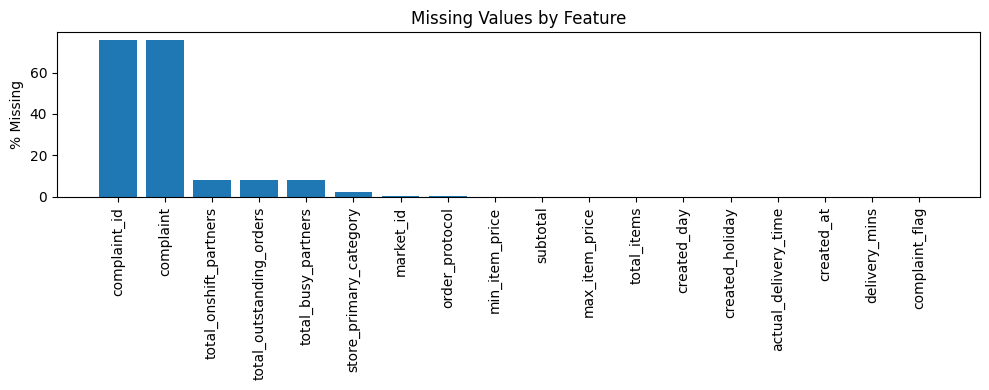

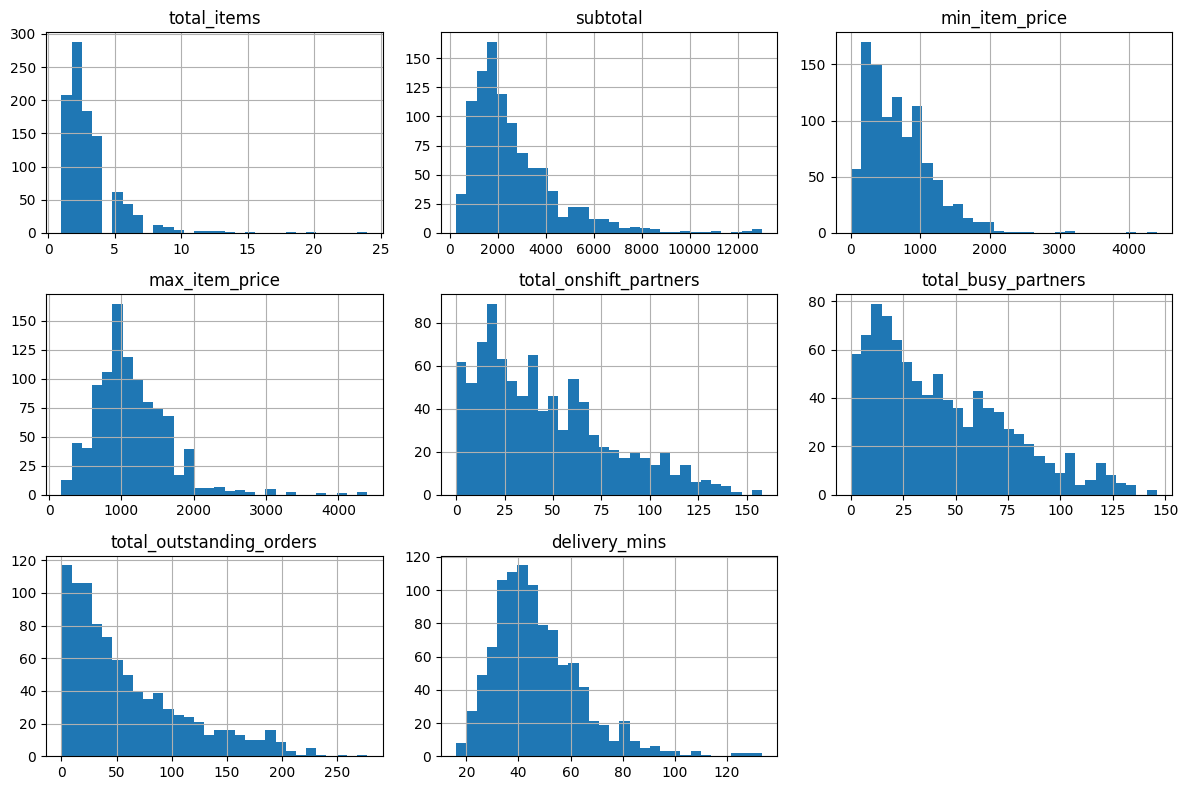

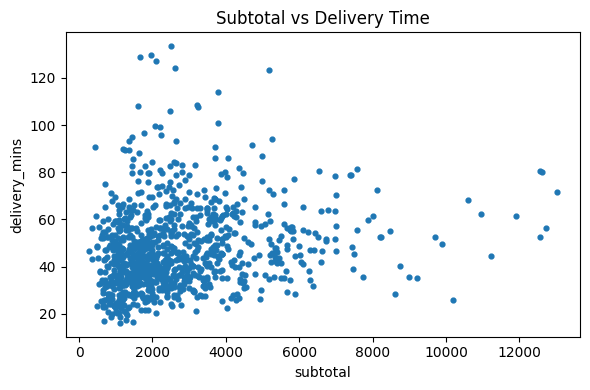

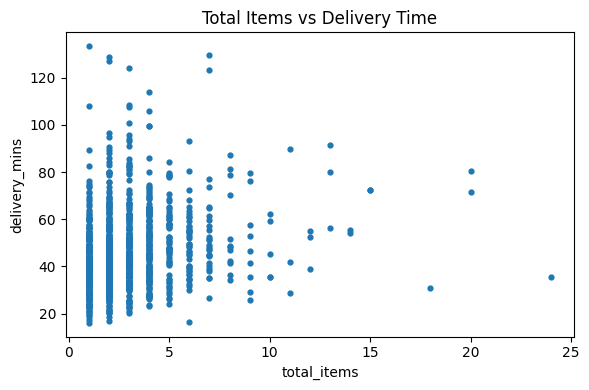

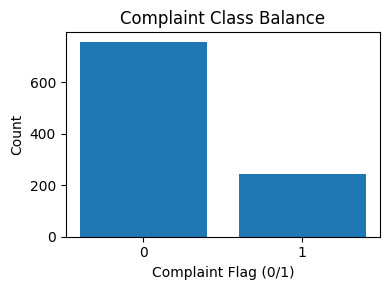

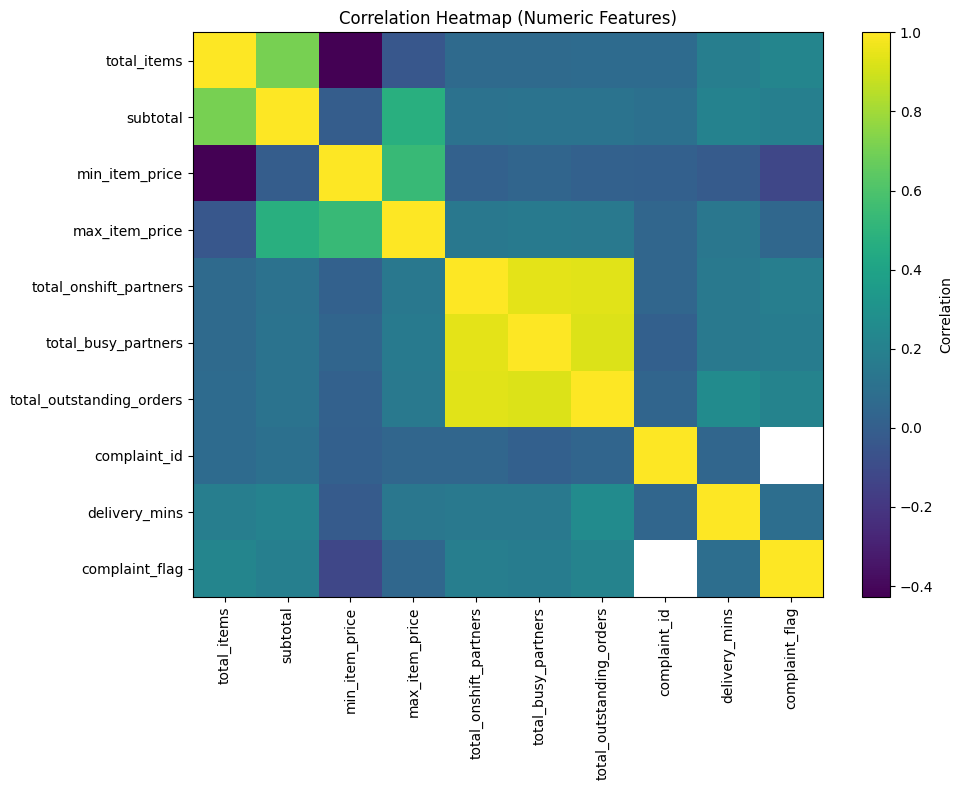

In [15]:
# -----------------------------
# Task A: EDA
# -----------------------------

def run_basic_eda(df: pd.DataFrame):
    print("\n--- Shape ---")
    print(df.shape)

    print("\n--- Columns ---")
    print(df.columns.tolist())

    print("\n--- Missingness (top 10) ---")
    miss = df.isna().mean().sort_values(ascending=False)
    print(miss.head(10))

    print("\n--- Delivery time summary (minutes) ---")
    print(df["delivery_mins"].describe())

    print("\n--- Complaint rate ---")
    print(df["complaint_flag"].value_counts())
    print("Complaint rate:", df["complaint_flag"].mean())

    # Missingness bar
    missing_pct = df.isna().mean().sort_values(ascending=False) * 100
    plt.figure(figsize=(10, 4))
    plt.bar(missing_pct.index.astype(str), missing_pct.values)
    plt.xticks(rotation=90)
    plt.ylabel("% Missing")
    plt.title("Missing Values by Feature")
    plt.tight_layout()
    plt.savefig(OUT_DIR / "eda_missing_values.png", dpi=200)
    plt.show()

    # Histograms for key numeric features
    numeric_cols = [
        "total_items", "subtotal", "min_item_price", "max_item_price",
        "total_onshift_partners", "total_busy_partners", "total_outstanding_orders",
        "delivery_mins"
    ]
    numeric_cols = [c for c in numeric_cols if c in df.columns]

    if numeric_cols:
        df[numeric_cols].hist(bins=30, figsize=(12, 8))
        plt.tight_layout()
        plt.savefig(OUT_DIR / "eda_numeric_histograms.png", dpi=200)
        plt.show()

    # Scatter: subtotal vs delivery time
    if "subtotal" in df.columns:
        plt.figure(figsize=(6, 4))
        plt.scatter(df["subtotal"], df["delivery_mins"], s=12)
        plt.xlabel("subtotal")
        plt.ylabel("delivery_mins")
        plt.title("Subtotal vs Delivery Time")
        plt.tight_layout()
        plt.savefig(OUT_DIR / "eda_subtotal_vs_delivery.png", dpi=200)
        plt.show()

    # Scatter: total_items vs delivery time
    if "total_items" in df.columns:
        plt.figure(figsize=(6, 4))
        plt.scatter(df["total_items"], df["delivery_mins"], s=12)
        plt.xlabel("total_items")
        plt.ylabel("delivery_mins")
        plt.title("Total Items vs Delivery Time")
        plt.tight_layout()
        plt.savefig(OUT_DIR / "eda_items_vs_delivery.png", dpi=200)
        plt.show()

    # Complaint class balance
    counts = df["complaint_flag"].value_counts(dropna=False)
    plt.figure(figsize=(4, 3))
    plt.bar(counts.index.astype(str), counts.values)
    plt.xlabel("Complaint Flag (0/1)")
    plt.ylabel("Count")
    plt.title("Complaint Class Balance")
    plt.tight_layout()
    plt.savefig(OUT_DIR / "eda_complaint_balance.png", dpi=200)
    plt.show()

    # Correlation heatmap (numeric)
    num = df.select_dtypes(include=[np.number]).copy()
    if not num.empty:
        corr = num.corr(numeric_only=True)
        plt.figure(figsize=(10, 8))
        plt.imshow(corr.values, aspect="auto")
        plt.colorbar(label="Correlation")
        plt.xticks(range(len(corr.columns)), corr.columns.astype(str), rotation=90)
        plt.yticks(range(len(corr.columns)), corr.columns.astype(str))
        plt.title("Correlation Heatmap (Numeric Features)")
        plt.tight_layout()
        plt.savefig(OUT_DIR / "eda_corr_heatmap.png", dpi=200)
        plt.show()


run_basic_eda(df)



Silhouette scores: {2: np.float64(0.14756159884592968), 3: np.float64(0.12147687843977825), 4: np.float64(0.12159351329262237), 5: np.float64(0.11660605703004047), 6: np.float64(0.10626664679446678), 7: np.float64(0.09800828983640282), 8: np.float64(0.09600028295117886), 9: np.float64(0.09174179822497934), 10: np.float64(0.09193489503411292)}
Chosen k: 2 best silhouette: 0.14756159884592968


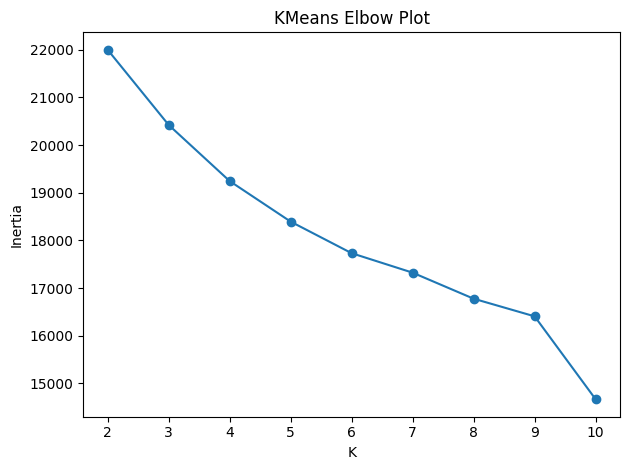

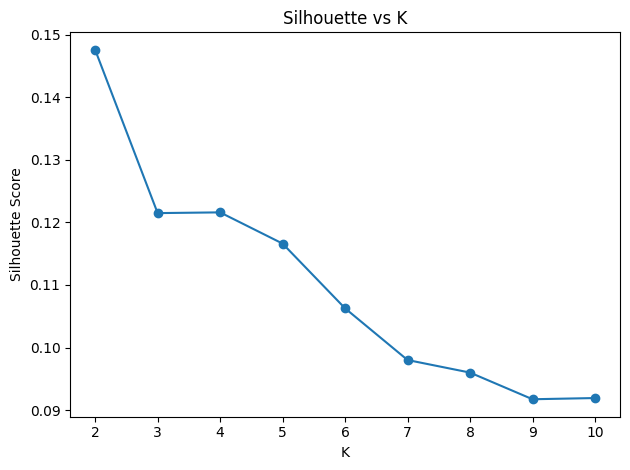

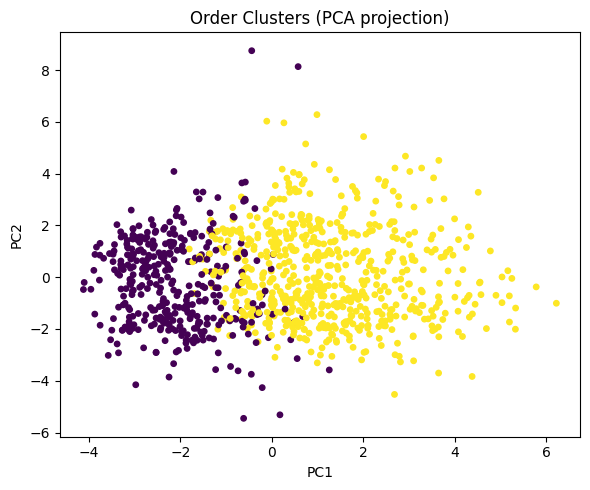


Representative rows per cluster:
   cluster  row_index  distance_to_centroid
0        0        780              2.858419
1        1        617              2.638208

Representative order details:

--- Cluster 0 | Row 780 ---
market_id                          AREA B
store_primary_category      mediterranean
order_protocol                 Protocol 3
total_items                             4
subtotal                             2696
min_item_price                        499
max_item_price                        799
total_onshift_partners               46.0
total_busy_partners                  38.0
total_outstanding_orders             46.0
created_day                       Tuesday
created_holiday                        NO
created_at                       20:28:39
Name: 780, dtype: object

--- Cluster 1 | Row 617 ---
market_id                       AREA A
store_primary_category        japanese
order_protocol              Protocol 3
total_items                          3
subtotal          

In [16]:
# -----------------------------
# Task A: Clustering
# -----------------------------

def cluster_orders(X: pd.DataFrame, k_min=2, k_max=10):
    # Clustering on engineered + preprocessed features.
    # Chooses k by best silhouette score.
    # Also saves a PCA 2D plot for visualization.
    feat = FeatureEngineer()
    pre = make_preprocessor(scale_numeric=True)

    # Prepare clustering matrix
    X_fe = feat.fit_transform(X)
    Z = pre.fit_transform(X_fe)

    # Pick k via silhouette
    best_k, best_score = None, -1
    scores = {}
    inertias = {}

    for k in range(k_min, k_max + 1):
        try:
            km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto")
        except TypeError:
            km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)

        labels = km.fit_predict(Z)
        score = silhouette_score(Z, labels)
        scores[k] = score
        inertias[k] = km.inertia_
        if score > best_score:
            best_k, best_score = k, score

    print("\nSilhouette scores:", scores)
    print("Chosen k:", best_k, "best silhouette:", best_score)

    # Plot elbow and silhouette
    ks = list(range(k_min, k_max + 1))
    plt.figure()
    plt.plot(ks, [inertias[k] for k in ks], marker="o")
    plt.xlabel("K")
    plt.ylabel("Inertia")
    plt.title("KMeans Elbow Plot")
    plt.tight_layout()
    plt.savefig(OUT_DIR / "cluster_elbow.png", dpi=200)
    plt.show()

    plt.figure()
    plt.plot(ks, [scores[k] for k in ks], marker="o")
    plt.xlabel("K")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette vs K")
    plt.tight_layout()
    plt.savefig(OUT_DIR / "cluster_silhouette.png", dpi=200)
    plt.show()

    # Fit final model
    try:
        km_final = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init="auto")
    except TypeError:
        km_final = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=10)

    labels = km_final.fit_predict(Z)

    # PCA plot
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    Z2 = pca.fit_transform(Z)

    plt.figure(figsize=(6, 5))
    plt.scatter(Z2[:, 0], Z2[:, 1], c=labels, s=15)
    plt.title("Order Clusters (PCA projection)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.savefig(OUT_DIR / "clusters_pca.png", dpi=200)
    plt.show()

    return labels, km_final, feat, pre, Z


def representative_examples(X_raw: pd.DataFrame, labels: np.ndarray, Z: np.ndarray, kmeans: KMeans, top_n=1):
    # Representative order(s) per cluster = closest point(s) to cluster centroid in feature space.
    reps = []
    for c in np.unique(labels):
        idx = np.where(labels == c)[0]
        centroid = kmeans.cluster_centers_[c]
        dists = np.linalg.norm(Z[idx] - centroid, axis=1)
        best = idx[np.argsort(dists)[:top_n]]
        for b in best:
            reps.append((c, b, dists[np.where(idx == b)[0][0]]))

    reps_df = pd.DataFrame(reps, columns=["cluster", "row_index", "distance_to_centroid"])
    reps_df = reps_df.sort_values(["cluster", "distance_to_centroid"]).reset_index(drop=True)

    print("\nRepresentative rows per cluster:")
    print(reps_df)

    print("\nRepresentative order details:")
    for _, r in reps_df.iterrows():
        c, i = int(r["cluster"]), int(r["row_index"])
        print(f"\n--- Cluster {c} | Row {i} ---")
        print(X_raw.iloc[i])

    return reps_df


# Use creation-time features only
X_clust = X.reset_index(drop=True)
labels, km, feat, pre, Z = cluster_orders(X_clust, k_min=2, k_max=10)
reps_df = representative_examples(X_clust, labels, Z, km, top_n=1)

# Save labels back to df for reporting
_df = df.reset_index(drop=True).copy()
_df["cluster"] = labels
_df.to_csv(OUT_DIR / "dataset_with_clusters.csv", index=False)
print("\nSaved:", OUT_DIR / "dataset_with_clusters.csv")



[Regression] CV results (train only):
          model     cv_MAE    cv_RMSE     cv_R2
2  RandomForest  11.398168  15.175427  0.146592
1         Ridge  11.749052  18.537402 -0.374895
0     DummyMean  12.522896  16.473377 -0.003878

Best RF params: {'model__n_estimators': 400, 'model__min_samples_leaf': 10, 'model__max_features': 0.5, 'model__max_depth': 10}
Best CV MAE: 11.04082536898056

[Regression] HOLDOUT TEST:
MAE: 12.568503603494499
RMSE: 17.047006731515246
R2: 0.20810403951082634


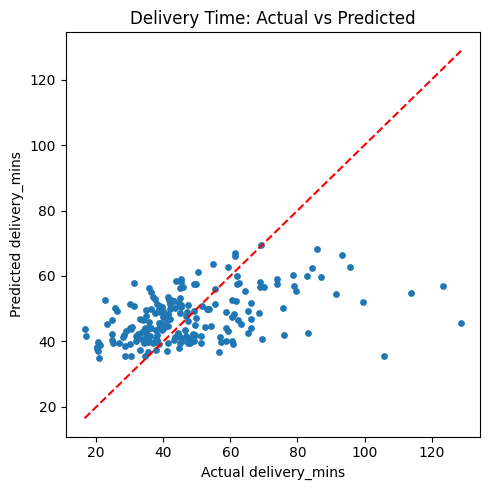

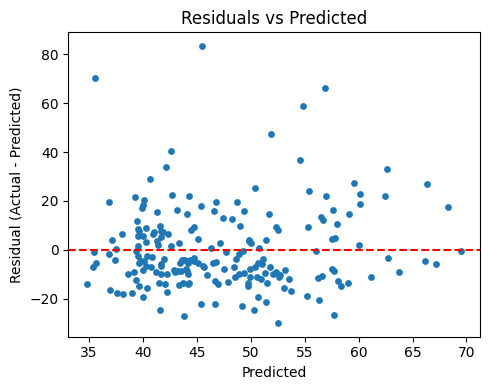

In [17]:
# -----------------------------
# Task B: Delivery Time Prediction
# -----------------------------

def evaluate_regression_models(X: pd.DataFrame, y: pd.Series):
    # Baselines + main model candidates with leakage-safe pipelines.
    # Reports CV results and final holdout test.
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE
    )

    feat = FeatureEngineer()
    pre = make_preprocessor(scale_numeric=True)

    def make_pipe(model):
        return Pipeline(steps=[
            ("feat", feat),
            ("pre", pre),
            ("model", model)
        ])

    models = {
        "DummyMean": DummyRegressor(strategy="mean"),
        "Ridge": Ridge(random_state=RANDOM_STATE),
        "RandomForest": RandomForestRegressor(
            n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1
        ),
    }

    # CV config
    cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    scoring = {
        "MAE": "neg_mean_absolute_error",
        "RMSE": "neg_root_mean_squared_error",
        "R2": "r2",
    }

    rows = []
    for name, model in models.items():
        pipe = make_pipe(model)
        cvres = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
        rows.append({
            "model": name,
            "cv_MAE": -cvres["test_MAE"].mean(),
            "cv_RMSE": -cvres["test_RMSE"].mean(),
            "cv_R2": cvres["test_R2"].mean(),
        })

    results = pd.DataFrame(rows).sort_values("cv_MAE")
    print("\n[Regression] CV results (train only):")
    print(results)

    # Hyperparameter tuning for main model (RandomForest example)
    rf_pipe = make_pipe(RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))

    param_dist = {
        "model__n_estimators": [200, 400, 600],
        "model__max_depth": [None, 6, 10, 16],
        "model__min_samples_leaf": [1, 2, 5, 10],
        "model__max_features": ["sqrt", 0.5, 0.8],
    }

    search = RandomizedSearchCV(
        rf_pipe,
        param_distributions=param_dist,
        n_iter=20,
        scoring="neg_mean_absolute_error",
        cv=cv,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    print("\nBest RF params:", search.best_params_)
    print("Best CV MAE:", -search.best_score_)

    # Final test evaluation
    pred = best_model.predict(X_test)
    test_mae = mean_absolute_error(y_test, pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, pred))
    test_r2 = r2_score(y_test, pred)

    print("\n[Regression] HOLDOUT TEST:")
    print("MAE:", test_mae)
    print("RMSE:", test_rmse)
    print("R2:", test_r2)

    # Plot predicted vs actual
    plt.figure(figsize=(5, 5))
    plt.scatter(y_test, pred, s=15)
    mn = min(y_test.min(), pred.min())
    mx = max(y_test.max(), pred.max())
    plt.plot([mn, mx], [mn, mx], color="red", linestyle="--")
    plt.xlabel("Actual delivery_mins")
    plt.ylabel("Predicted delivery_mins")
    plt.title("Delivery Time: Actual vs Predicted")
    plt.tight_layout()
    plt.savefig(OUT_DIR / "reg_actual_vs_pred.png", dpi=200)
    plt.show()

    # Residuals vs predicted
    res = y_test - pred
    plt.figure(figsize=(5, 4))
    plt.scatter(pred, res, s=15)
    plt.axhline(0, color="red", linestyle="--")
    plt.xlabel("Predicted")
    plt.ylabel("Residual (Actual - Predicted)")
    plt.title("Residuals vs Predicted")
    plt.tight_layout()
    plt.savefig(OUT_DIR / "reg_residuals.png", dpi=200)
    plt.show()

    return best_model, results, search


best_reg_model, reg_cv_table, reg_search = evaluate_regression_models(X, y_reg)



[Classification] CV results (train only):
                  model  cv_ROC_AUC  cv_PR_AUC     cv_F1
2  RandomForestBalanced    0.614304   0.387469  0.193491
3  BalancedRandomForest    0.617377   0.383414  0.383602
1        LogRegBalanced    0.621827   0.361020  0.406082
0         DummyMostFreq    0.500000   0.243750  0.000000

Best model params: {'model__n_estimators': 400, 'model__min_samples_leaf': 10, 'model__max_features': 'sqrt', 'model__max_depth': 10}
Best CV PR-AUC: 0.41162943361200177

[Classification] HOLDOUT TEST:
ROC-AUC: 0.6919854034328964
PR-AUC : 0.4819961960535132
F1     : 0.45217391304347826
Precision: 0.3939393939393939
Recall   : 0.5306122448979592

Confusion matrix (threshold=0.5):
[[111  40]
 [ 23  26]]


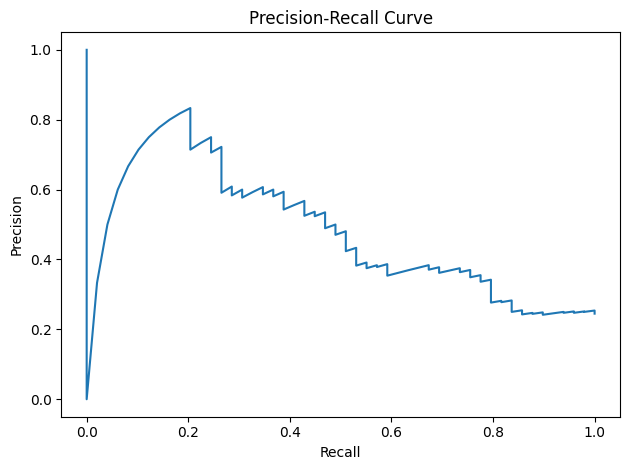

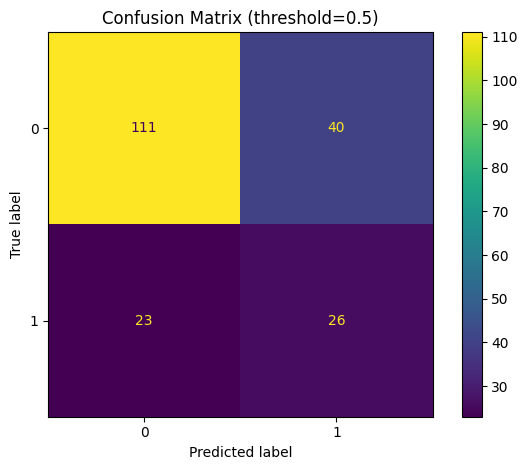

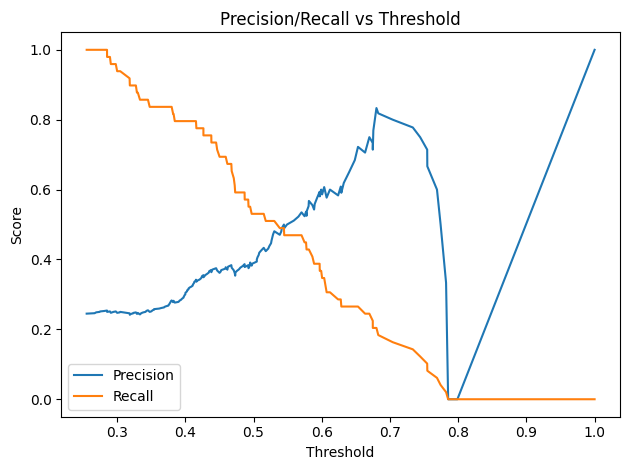

In [18]:
# -----------------------------
# Task C: Complaint Prediction
# -----------------------------

def evaluate_classification_models(X: pd.DataFrame, y: pd.Series):
    # Baselines + main model candidates with leakage-safe pipelines.
    # Uses metrics suitable for imbalance: ROC-AUC and PR-AUC.
    # Also prints a threshold-based confusion matrix.
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )

    feat = FeatureEngineer()
    pre = make_preprocessor(scale_numeric=True)

    def make_pipe(model):
        return Pipeline(steps=[
            ("feat", feat),
            ("pre", pre),
            ("model", model)
        ])

    models = {
        "DummyMostFreq": DummyClassifier(strategy="most_frequent"),
        "LogRegBalanced": LogisticRegression(
            max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE
        ),
        "RandomForestBalanced": RandomForestClassifier(
            n_estimators=400, random_state=RANDOM_STATE, class_weight="balanced", n_jobs=-1
        ),
    }

    if HAS_IMBLEARN:
        models["BalancedRandomForest"] = BalancedRandomForestClassifier(
            n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1
        )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    rows = []
    for name, model in models.items():
        pipe = make_pipe(model)
        cvres = cross_validate(
            pipe, X_train, y_train,
            cv=cv,
            scoring={
                "roc_auc": "roc_auc",
                "pr_auc": "average_precision",
                "f1": "f1"
            },
            n_jobs=-1
        )
        rows.append({
            "model": name,
            "cv_ROC_AUC": cvres["test_roc_auc"].mean(),
            "cv_PR_AUC": cvres["test_pr_auc"].mean(),
            "cv_F1": cvres["test_f1"].mean(),
        })

    results = pd.DataFrame(rows).sort_values("cv_PR_AUC", ascending=False)
    print("\n[Classification] CV results (train only):")
    print(results)

    # Tune a main model
    if HAS_IMBLEARN:
        base_model = BalancedRandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
    else:
        base_model = RandomForestClassifier(random_state=RANDOM_STATE, class_weight="balanced", n_jobs=-1)

    clf_pipe = make_pipe(base_model)

    param_dist = {
        "model__n_estimators": [200, 400, 800],
        "model__max_depth": [None, 6, 10, 16],
        "model__min_samples_leaf": [1, 2, 5, 10],
        "model__max_features": ["sqrt", 0.5, 0.8],
    }

    search = RandomizedSearchCV(
        clf_pipe,
        param_distributions=param_dist,
        n_iter=20,
        scoring="average_precision",   # PR-AUC
        cv=cv,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    print("\nBest model params:", search.best_params_)
    print("Best CV PR-AUC:", search.best_score_)

    # Final test evaluation
    prob = best_model.predict_proba(X_test)[:, 1]
    test_roc = roc_auc_score(y_test, prob)
    test_pr = average_precision_score(y_test, prob)

    # Default threshold 0.5
    y_hat = (prob >= 0.5).astype(int)
    test_f1 = f1_score(y_test, y_hat)
    test_prec = precision_score(y_test, y_hat, zero_division=0)
    test_rec = recall_score(y_test, y_hat, zero_division=0)

    print("\n[Classification] HOLDOUT TEST:")
    print("ROC-AUC:", test_roc)
    print("PR-AUC :", test_pr)
    print("F1     :", test_f1)
    print("Precision:", test_prec)
    print("Recall   :", test_rec)
    print("\nConfusion matrix (threshold=0.5):")
    print(confusion_matrix(y_test, y_hat))

    # PR curve
    precision, recall, thresholds = precision_recall_curve(y_test, prob)
    plt.figure()
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.tight_layout()
    plt.savefig(OUT_DIR / "clf_pr_curve.png", dpi=200)
    plt.show()

    # Confusion matrix plot
    cm = confusion_matrix(y_test, y_hat)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title("Confusion Matrix (threshold=0.5)")
    plt.tight_layout()
    plt.savefig(OUT_DIR / "clf_confusion_matrix.png", dpi=200)
    plt.show()

    # Threshold trade-off
    th_plot = np.r_[thresholds, 1.0]
    plt.figure()
    plt.plot(th_plot, precision, label="Precision")
    plt.plot(th_plot, recall, label="Recall")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Precision/Recall vs Threshold")
    plt.legend()
    plt.tight_layout()
    plt.savefig(OUT_DIR / "clf_threshold_tradeoff.png", dpi=200)
    plt.show()

    return best_model, results, search


best_clf_model, clf_cv_table, clf_search = evaluate_classification_models(X, y_clf)


In [19]:
reg_cv_table.to_csv(OUT_DIR / "regression_cv_results.csv", index=False)
clf_cv_table.to_csv(OUT_DIR / "classification_cv_results.csv", index=False)

print("Saved CV tables to", OUT_DIR)


Saved CV tables to outputs
